### Initialization:

In [1]:
import keras
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import numpy as np
import cv2
import imageio

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add, Input
# from keras.layers.convolutional import Conv2D
from keras.layers import Conv2D,MaxPooling2D, BatchNormalization
from keras.utils import np_utils

from keras.datasets import mnist

Using TensorFlow backend.


### Load the Dataset:

In [2]:
(X_train, Y_train),(X_test, Y_test) = mnist.load_data()
print(len(X_train), len(Y_train))

60000 60000


### Data Augumentation

In [3]:
augmented_X, augmented_Y = [], []

blurer = iaa.GaussianBlur(3.0)
noise = iaa.AdditiveGaussianNoise(scale=0.1*255)
coarse_dropout = iaa.CoarseDropout(p=0.2, size_percent=0.05)
# perspetive = iaa.PerspectiveTransformation(scale=0.075)

for image,label in zip(X_train, Y_train):
#     augmented_X.append(image)
#     augmented_Y.append(label)
    
#     augmented_X.append(noise.augment_image(image))
#     augmented_Y.append(label)

#     augmented_X.append(coarse_dropout.augment_image(image))
#     augmented_Y.append(label)

#     augmented_X.append(perspetive.augment_image(image))
#     augmented_Y.append(label)
    
#     augmented_X.append(cv2.GaussianBlur(image,(3,3),3))
#     augmented_Y.append(label)
    
    augmented_X.append(cv2.equalizeHist(image))
    augmented_Y.append(label)

### Data Conversion

In [4]:
# Convert Images and Steering values to numpy arrays since keras requires them in that form
X_train = np.array(augmented_X)
Y_train = np.array(augmented_Y)
print(len(X_train), len(Y_train))

60000 60000


### Data Sample:

(60000, 28, 28)
8


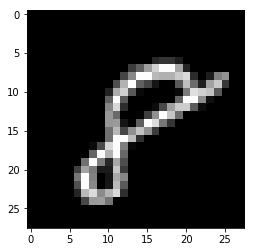

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

print(X_train.shape)
print(Y_train[60000-1])
# print(X_train.shape)
plt.imshow(X_train[60000-1], cmap='gray')
# plt.imshow(X_train[120000-1], cmap='gray')
# plt.imshow(X_train[180000-1], cmap='gray')
# plt.imshow(X_train[240000-1], cmap='gray')

### Reshape the Input:
    We need to reshape the input as new Keras API expects us to mention the total color-channels as well (1 in our case as we have grayscale images).

In [6]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
# print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

### Conversion and Normalization:
All images are stored as unit8, however, we work with floats in neural network. So first thing we do is to convert our images from uint8 to float32. Then, we convert our images from 0-255 scale to 0-1. This is called normalization. We usually do this because:

- 0-1 is easier to deal with.
- keeping other variables within a range (0-1) becomes easier if inputs are also between (0-1).
- keeping values between (0-1) also, sort of, adds an in-built threshold (0.9*0.9 = 0.81, but 229*229 = 52441).

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# X_train = X_train / 255
# X_test = X_test / 255

### One Hot Encoding:

In [8]:
num_classes = 10

y_train = np_utils.to_categorical(Y_train, num_classes)
y_test = np_utils.to_categorical(Y_test, num_classes)

### Model:

In [9]:
input1 = Input(shape=(28, 28, 1,))

# Layer 1: Input => [28x28x1],1
#          Output => [26x26x**],**
layer1 = Conv2D(32, (3,3), name='conv_1')(input1)
layer1 = BatchNormalization(name='norm_1')(layer1)
layer1 = Activation('relu')(layer1)
layer1 = Dropout(0.2)(layer1)

# Layer 2: Input => [26x26x**],**
#          Output => [24x24x**],**
layer2 = Conv2D(16, (3,3), name='conv_2')(layer1)
layer2 = BatchNormalization(name='norm_2')(layer2)
layer2 = Activation('relu')(layer2)
layer2 = Dropout(0.2)(layer2)

# Layer 3: Input => [24x24x**],**
#          Output => [12x12x**],**
layer3 = Conv2D(32, (1,1), name='conv_3')(layer2)
layer3 = BatchNormalization(name='norm_3')(layer3)
layer3 = MaxPooling2D(pool_size=(2, 2))(layer3)

# Layer 4: Input => [12x12x**],**
#          Output => [10x10x**],**
layer4 = Conv2D(32, (3,3), name='conv_4')(layer3)
layer4 = BatchNormalization(name='norm_4')(layer4)
layer4 = Dropout(0.2)(layer4)

# Layer 5: Input => [10x10x**],**
#          Output => [10x10x**],**
layer5 = Conv2D(10, (1,1), name='conv_5')(layer4)
layer5 = BatchNormalization(name='norm_5')(layer5)
layer5 = Activation('relu')(layer5)
layer5 = Dropout(0.2)(layer5)

# Layer 6: Input => [10x10x**],**
#          Output => [8x8x**],**
layer6 = Conv2D(10, (3,3), name='conv_6')(layer5)
layer6 = BatchNormalization(name='norm_6')(layer6)
layer6 = Dropout(0.2)(layer6)

# Layer 7: Input => [8x8x**],**
#          Output => [3x3x**],**
layer7 = Conv2D(10, (3,3), name='conv_7')(layer6)
layer7 = BatchNormalization(name='norm_7')(layer7)
layer7 = Dropout(0.2)(layer7)
layer7 = MaxPooling2D(pool_size=(2, 2))(layer7)

# Layer 8: Input => [3x3x**],**
#          Output => [1x1x**],**
layer8 = Conv2D(10, (3,3), name='conv_8')(layer7)
layer8 = BatchNormalization(name='norm_8')(layer8)
layer8 = Dropout(0.2)(layer8)

# Layer 9
layer9 = Flatten()(layer8)
output = Dense(num_classes, activation='softmax')(layer9)


model = Model(inputs=[input1], outputs=[output])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 24, 16)        4624      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 24, 24, 16)        64        
__________

### Compile Model:

In [10]:
model.compile(loss='categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

### Train the Model:

In [11]:
model.fit(X_train, y_train, batch_size=64, epochs=25, verbose=1)

Epoch 1/50
60000/60000 [==============================] - 18s 302us/step - loss: 1.1353 - acc: 0.6552
Epoch 2/50
60000/60000 [==============================] - 16s 267us/step - loss: 0.5253 - acc: 0.8508
Epoch 3/50
60000/60000 [==============================] - 16s 268us/step - loss: 0.3728 - acc: 0.8904
Epoch 4/50
60000/60000 [==============================] - 16s 270us/step - loss: 0.3001 - acc: 0.9103
Epoch 5/50
60000/60000 [==============================] - 16s 269us/step - loss: 0.2573 - acc: 0.9232
Epoch 6/50
60000/60000 [==============================] - 16s 270us/step - loss: 0.2327 - acc: 0.9300
Epoch 7/50
60000/60000 [==============================] - 16s 272us/step - loss: 0.2172 - acc: 0.9339
Epoch 8/50
60000/60000 [==============================] - 16s 274us/step - loss: 0.1966 - acc: 0.9404
Epoch 9/50
60000/60000 [==============================] - 17s 276us/step - loss: 0.1904 - acc: 0.9417
Epoch 10/50
60000/60000 [==============================] - 17s 276us/step - loss: 

### Evalute:

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print(score[1]*100, '%')

98.09 %


[4.1441726e-03 6.8786321e-03 9.8894775e-01 1.1920223e-05 7.8576136e-07
 3.0849616e-08 7.5123644e-06 7.7172726e-06 1.3836625e-06 6.4370738e-08]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


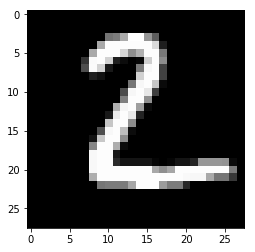

In [15]:
# manual test
y_pred = model.predict(X_test)
print(y_pred[1])
print(y_test[1])

X_test = X_test.reshape(X_test.shape[0], 28, 28)
X_test *= 255
%matplotlib inline
plt.imshow(X_test[1], cmap='gray')

### Save Model:

In [16]:
model.save('version1.h5')

### Load Model:

In [17]:
from keras.models import load_model

model1 = load_model('version1.h5')

### Test loading test:

In [18]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 24, 16)        4624      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 24, 24, 16)        64        
__________